# 🧪 Lab: Chunking and Indexing for Retrieval-Augmented Generation (RAG)

## 🔍 Scenario
You are a data engineer working for a health research organization. Your team is building a Retrieval-Augmented Generation (RAG) system to help researchers, doctors, and analysts query critical documents like CDC guidelines, WHO protocols, and medical articles using large language models (LLMs).

To ensure the system returns highly relevant and accurate results, you must:
- Clean and preprocess semi-structured documents,
- Apply appropriate chunking strategies,
- Generate embeddings,
- Store the results in Delta Lake,
- And finally, index them for semantic search using Databricks Vector Search.

Your goal in this lab is to simulate a real-world pipeline and observe how chunk size and granularity impact the quality of retrieved answers.

---

## 🎯 Objective

By the end of this lab, you will be able to:

- Extract and clean text from public PDF medical documents
- Apply sentence-based chunking with overlap to create coherent chunks
- Convert chunked text into Delta format and generate vector embeddings using a hosted embedding endpoint
- Index the embedded chunks using Databricks Vector Search
- Perform similarity-based queries using natural language prompts
- Simulate how chunk size affects retrieval precision using a post-query evaluation

This lab aligns with the learning objective of Chapter 3:

> **"Implement effective data chunking, filtering, and structuring strategies that enhance retrieval quality in RAG pipelines."**


## ⚙️ Step 1: Install Required Libraries

We’ll begin by installing the following:

- **`pymupdf`**: For extracting text from PDF documents
- **`databricks-sdk`**: To interact with Databricks REST APIs
- **`databricks-vectorsearch`**: To build and query vector search indexes on Delta tables

You only need to run this once per cluster.

```python
# If not already installed
%pip install --quiet pymupdf databricks-sdk --upgrade databricks-vectorsearch


In [0]:
# If not already installed
%pip install --quiet  pymupdf databricks-sdk --upgrade databricks-vectorsearch 



Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

## 📄 Step 2: Download Sample Documents to DBFS

We will download two public documents to simulate real-world RAG scenarios:

- **CDC COVID-19 FAQ**
- **WHO Clinical Guidelines**

These files will be saved to your Databricks FileStore under `/dbfs/FileStore/rag_docs`.


In [0]:
import os
import requests

# Define DBFS directory
dbfs_path = "/dbfs/FileStore/rag_docs"
os.makedirs(dbfs_path, exist_ok=True)  # Create directory if it doesn't exist

# List of documents to download
documents = {
    "cdc_faq.pdf": "https://www.cdc.gov/coronavirus/2019-ncov/downloads/2019-ncov-factsheet.pdf",
    "who_guidelines.pdf": "https://apps.who.int/iris/bitstream/handle/10665/338882/WHO-2019-nCoV-clinical-2021.1-eng.pdf"
}

# Download and save to DBFS
for filename, url in documents.items():
    print(f"📥 Downloading {filename}...")
    response = requests.get(url)
    full_path = os.path.join(dbfs_path, filename)
    with open(full_path, "wb") as f:
        f.write(response.content)
    print(f"✅ File saved to {full_path}")


dbutils.fs.ls("dbfs:/FileStore/rag_docs/")

📥 Downloading cdc_faq.pdf...
✅ File saved to /dbfs/FileStore/rag_docs/cdc_faq.pdf
📥 Downloading who_guidelines.pdf...
✅ File saved to /dbfs/FileStore/rag_docs/who_guidelines.pdf


[FileInfo(path='dbfs:/FileStore/rag_docs/cdc_faq.pdf', name='cdc_faq.pdf', size=20970, modificationTime=1751503623000),
 FileInfo(path='dbfs:/FileStore/rag_docs/cdc_faq_clean.txt', name='cdc_faq_clean.txt', size=1922, modificationTime=1751499640000),
 FileInfo(path='dbfs:/FileStore/rag_docs/who_guidelines.pdf', name='who_guidelines.pdf', size=2499497, modificationTime=1751503625000),
 FileInfo(path='dbfs:/FileStore/rag_docs/who_guidelines_clean.txt', name='who_guidelines_clean.txt', size=307981, modificationTime=1751499641000)]

## 🧹 Step 3: Extract and Clean PDF Text

We will now use **PyMuPDF (`fitz`)** to extract raw text from the downloaded PDFs and clean it using a simple text-processing function.

This step ensures:
- Removal of extra whitespace and line breaks
- Stripping out headers like "Page 1", "Page 2", etc.
- Clean formatting for downstream chunking and embedding




In [0]:
import os
import fitz  # This is PyMuPDF
import re

# Ensure target directory exists
dbfs_dir = "/dbfs/FileStore/rag_docs"
os.makedirs(dbfs_dir, exist_ok=True)

# Utility: Clean extracted text
def clean_text(text):
    text = re.sub(r"\n+", "\n", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"Page \d+", "", text, flags=re.IGNORECASE)
    return text.strip()

# Utility: Extract text from PDF using PyMuPDF
def extract_pdf_text(pdf_path):
    doc = fitz.open(pdf_path)
    full_text = ""
    for page in doc:
        full_text += page.get_text()
    return clean_text(full_text)

# Extract and clean both documents
cdc_pdf_path = "/dbfs/FileStore/rag_docs/cdc_faq.pdf"
who_pdf_path = "/dbfs/FileStore/rag_docs/who_guidelines.pdf"

cdc_text = extract_pdf_text(cdc_pdf_path)
who_text = extract_pdf_text(who_pdf_path)

# Save cleaned text files to DBFS
cdc_txt_path = "/dbfs/FileStore/rag_docs/cdc_faq_clean.txt"
who_txt_path = "/dbfs/FileStore/rag_docs/who_guidelines_clean.txt"

with open(cdc_txt_path, "w") as f:
    f.write(cdc_text)

with open(who_txt_path, "w") as f:
    f.write(who_text)

print("✅ Text extracted and saved as:")
print(f" - {cdc_txt_path}")
print(f" - {who_txt_path}")


✅ Text extracted and saved as:
 - /dbfs/FileStore/rag_docs/cdc_faq_clean.txt
 - /dbfs/FileStore/rag_docs/who_guidelines_clean.txt


## ✂️ Step 4: Apply Sentence-Level Chunking and Save as Delta Table

In this step, we divide the cleaned text documents into **overlapping chunks** using a sentence-based strategy.

### What happens in this step:
- The CDC and WHO text files are loaded.
- A chunking function splits the text into blocks of ~200 words, with a 50-word overlap between adjacent chunks.
- Each chunk is stored along with metadata such as:
  - `source` (document origin)
  - `chunk_id` (sequence)
  - `text` (the chunk content)
- The result is saved as a Delta table in `/tmp/rag_chunks` for downstream processing.

Chunking helps improve retrieval by giving the model smaller, coherent pieces of text that are easier to match with user queries.


In [0]:
import os
import pandas as pd
import nltk
nltk.download("punkt")
from nltk.tokenize import sent_tokenize

# Define file paths
dbfs_dir = "/dbfs/FileStore/rag_docs"
cdc_txt_path = os.path.join(dbfs_dir, "cdc_faq_clean.txt")
who_txt_path = os.path.join(dbfs_dir, "who_guidelines_clean.txt")
delta_output_path = "/tmp/rag_chunks"  # Spark will write Delta here

# Load cleaned text
with open(cdc_txt_path, "r") as f:
    cdc_text = f.read()

with open(who_txt_path, "r") as f:
    who_text = f.read()

# Document metadata structure
documents = [
    {"source": "cdc_faq", "text": cdc_text},
    {"source": "who_guidelines", "text": who_text}
]

# Define chunking logic
def chunk_text(text, chunk_size=200, overlap=50):
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = []
    current_length = 0

    for sentence in sentences:
        words = sentence.split()
        sentence_len = len(words)
        if current_length + sentence_len > chunk_size:
            chunks.append(" ".join(current_chunk))
            current_chunk = current_chunk[-overlap:] if overlap else []
            current_length = sum(len(s.split()) for s in current_chunk)
        current_chunk.extend(words)
        current_length += sentence_len

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

# Apply chunking
all_chunks = []
for doc in documents:
    chunks = chunk_text(doc["text"], chunk_size=200, overlap=50)
    for i, chunk in enumerate(chunks):
        all_chunks.append({
            "source": doc["source"],
            "chunk_id": i,
            "text": chunk
        })

# Convert to Spark DataFrame and write to Delta
chunk_df = pd.DataFrame(all_chunks)
spark_df = spark.createDataFrame(chunk_df)

spark_df.write.mode("overwrite").format("delta").save(delta_output_path)

print(f"✅ Chunking complete and Delta saved at: {delta_output_path}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


✅ Chunking complete and Delta saved at: /tmp/rag_chunks


## 🧠 Step 5: Create an Embedding Endpoint in Databricks

To convert our text chunks into vector embeddings, we will use a **pretrained embedding model** hosted as a **Databricks Model Serving endpoint**.

Databricks offers a variety of foundation models that you can deploy quickly, including the BGE (`databricks-bge-large-en`) embedding model.

### 🔧 Steps to Create the Embedding Endpoint

1. **Go to the "Serving" tab** in your Databricks workspace UI.
   - You can access it by navigating to:  
     `Workspace → Machine Learning → Serving Endpoints`

2. **Click "Create Endpoint"**

3. Fill in the form with the following values:
   - **Name**: `databricks-bge-large-en`
   - **Served Model**:
     - **Select Model**: `databricks-bge-large-en`
     - **Task**: `embedding`
     - **Model Version**: Use the latest available

4. Click **Create** and wait for the endpoint status to show **ONLINE**
 

 

## 🔢 Step 6: Generate Embeddings for Chunked Text

Now that we have a running embedding endpoint (`databricks-bge-large-en`), we'll use it to convert each chunk of text into a high-dimensional vector representation.

This vector (or "embedding") captures the **semantic meaning** of the chunk, which is essential for similarity search in RAG systems.

### What this step does:
- Defines a `pandas_udf` function to call the model serving endpoint in batches
- Sends each batch of text chunks to the endpoint using the Databricks REST API
- Receives vector embeddings in return
- Converts and validates the embeddings as arrays of floats
- Returns the result as a new column in the Spark DataFrame

We batch the requests for efficiency and handle conversion to a `float32` format for compatibility with downstream vector search.

📌 **Note**: The code uses the current user's API token from the notebook context for secure authorization.


In [0]:
import requests
import json
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import ArrayType, FloatType
import pandas as pd
from typing import Iterator

# Databricks REST endpoint and token
endpoint_url = "https://adb-3141834805281315.15.azuredatabricks.net/serving-endpoints/databricks-bge-large-en/invocations"
token = dbutils.notebook.entry_point.getDbutils().notebook().getContext().apiToken().get()
 
headers = {
    "Authorization": f"Bearer {token}",
    "Content-Type": "application/json"
}
@pandas_udf(ArrayType(FloatType()))
def get_embeddings_udf(texts: Iterator[pd.Series]) -> Iterator[pd.Series]:
    for batch in texts:
        try:
            clean_batch = batch.dropna().astype(str)
            clean_batch = clean_batch[clean_batch.str.len() > 10]

            max_batch_size = 10
            chunks = [clean_batch[i:i+max_batch_size] for i in range(0, len(clean_batch), max_batch_size)]
            all_embeddings = []

            for chunk in chunks:
                payload = {"input": chunk.tolist()}
                response = requests.post(endpoint_url, headers=headers, json=payload)
                response.raise_for_status()

                # FIX HERE: extract actual embeddings from dict
                vectors = [item["embedding"] for item in response.json().get("data", [])]
                all_embeddings.extend(vectors)

            # Ensure conversion to float arrays
            import numpy as np
            validated = pd.Series([np.array(vec, dtype=np.float32).tolist() for vec in all_embeddings])
            yield validated

        except Exception as e:
            print("❌ UDF embedding failure:", str(e))
            raise e



## 💾 Step 7: Save Embedded Chunks to Delta

In this step, we apply the embedding UDF defined earlier to each chunk of text, and save the resulting vector-enriched dataset.

### What this step does:
- Loads the chunked data stored in Delta format from `/tmp/rag_chunks`
- Applies the embedding UDF to the `text` column
- Adds a new `embedding` column containing a vector for each chunk
- Saves the resulting DataFrame as a new Delta table at `/tmp/rag_chunks_embedded`

This table serves as the input for indexing in the next step using Databricks Vector Search.


In [0]:
# Load chunks from previous step
chunk_df = spark.read.format("delta").load("/tmp/rag_chunks")

# Embed and add embeddings column
embedded_df = chunk_df.withColumn("embedding", get_embeddings_udf("text"))

# Save to new Delta location
embedded_df.write.mode("overwrite").format("delta").save("/tmp/rag_chunks_embedded")

print("✅ Embedded chunks saved at /tmp/rag_chunks_embedded")


✅ Embedded chunks saved at /tmp/rag_chunks_embedded


## 🧭 Step 8: Create a Vector Search Endpoint and Index

Now that our document chunks have embeddings, we will set up a **Vector Search index** to enable fast and semantic retrieval.

### What this step does:
- Uses the `databricks-vectorsearch` SDK to connect to a pre-created vector search endpoint (e.g., `orielly-chapter2-endpoint`)
- Points the index to the Delta table at `/tmp/rag_chunks_embedded`
- Automatically uses the `embedding` column for indexing
- Uses a primary key such as `chunk_id` and `source` for deduplication and tracking
- Sets the sync mode to `TRIGGERED` so that changes to the Delta table can be reflected in the index as needed

After this step, the vector index will be able to serve similarity-based searches over semantically embedded chunks.


In [0]:
from databricks.vector_search.client import VectorSearchClient
import time

VECTOR_SEARCH_ENDPOINT_NAME = "orielly-chapter2-endpoint"
vsc = VectorSearchClient(disable_notice=True)

def endpoint_exists(vsc, endpoint_name):
    try:
        vsc.get_endpoint(endpoint_name)
        return True
    except Exception as e:
        if "NOT_FOUND" in str(e) or "does not exist" in str(e):
            return False
        raise e

def wait_for_vs_endpoint_to_be_ready(vsc, endpoint_name, timeout=700, poll_interval=15):
    start_time = time.time()
    while True:
        try:
            status = vsc.get_endpoint(endpoint_name).get("endpoint_status", {}).get("state", "")
            print(f"Status: {status}")
            if status == "ONLINE":
                print(f"✅ Vector Search endpoint '{endpoint_name}' is ready.")
                break
        except Exception as e:
            print(f"[WARN] Failed to get endpoint status: {e}")

        if time.time() - start_time > timeout:
            raise TimeoutError(f"❌ Timeout: Endpoint '{endpoint_name}' was not ready after {timeout} seconds.")
        time.sleep(poll_interval)

# 🚀 Create endpoint if needed
if not endpoint_exists(vsc, VECTOR_SEARCH_ENDPOINT_NAME):
    print(f"🚀 Creating Vector Search endpoint: {VECTOR_SEARCH_ENDPOINT_NAME}")
    vsc.create_endpoint(name=VECTOR_SEARCH_ENDPOINT_NAME, endpoint_type="STANDARD")
    time.sleep(5)  # Allow time for provisioning to start
else:
    print(f"ℹ️ Vector Search endpoint '{VECTOR_SEARCH_ENDPOINT_NAME}' already exists.")

# ⏳ Wait for it to be ready
wait_for_vs_endpoint_to_be_ready(vsc, VECTOR_SEARCH_ENDPOINT_NAME)

ℹ️ Vector Search endpoint 'orielly-chapter2-endpoint' already exists.
Status: ONLINE
✅ Vector Search endpoint 'orielly-chapter2-endpoint' is ready.


## 🗂️ Step 8.1: Register Embedded Delta Table

To simplify integration with Vector Search and allow for querying with SQL, you can register the embedded Delta dataset as a managed table.

### What this step does:
- Loads the Delta file from `/tmp/rag_chunks_embedded`
- Registers it as a table in the Unity Catalog or Hive Metastore (e.g., `main.default.rag_chunks_embedded`)
- Makes the table accessible for indexing, querying, or syncing with Vector Search

📌 **Note**: If your Vector Search index was already created from a Delta table reference, this step may be skipped unless re-registration is needed.

In [0]:
# Register as a table if needed (or skip if already done)
spark.read.format("delta").load("/tmp/rag_chunks_embedded").write.mode("overwrite").saveAsTable("main.default.rag_chunks_embedded")


## 🧠 Step 9: Create and Sync a Vector Search Index

Now that the embedded document chunks have been saved to a Delta table, we’ll create a **Vector Search index** so we can perform fast similarity searches.

This step uses the `databricks-vectorsearch` SDK to programmatically register the index and sync it with your Delta table.

### What this step does:
- Initializes the `VectorSearchClient`
- Enables **Change Data Feed (CDF)** on the Delta table to allow syncing
- Checks if the index already exists on the specified endpoint
- Creates the index


In [0]:
from databricks.vector_search.client import VectorSearchClient
import time

# Configuration (update catalog/schema/table if different)
catalog = "main"
schema = "default"
table = "rag_chunks_embedded"
index = "rag_chunks_index"

VECTOR_SEARCH_ENDPOINT_NAME = "orielly-chapter2-endpoint"
EMBEDDING_ENDPOINT_NAME = "databricks-bge-large-en"

source_table_fullname = f"{catalog}.{schema}.{table}"
vs_index_fullname = f"{catalog}.{schema}.{index}"

# Initialize Vector Search Client
vsc = VectorSearchClient(disable_notice=True)

# ✅ Enable Change Data Feed (required for triggered sync)
try:
    spark.sql(f"ALTER TABLE {source_table_fullname} SET TBLPROPERTIES (delta.enableChangeDataFeed = true)")
    print(f"[INFO] CDF enabled on {source_table_fullname}")
except Exception as e:
    print(f"[WARN] Could not enable CDF (maybe already enabled): {e}")

# ✅ Check if index already exists
def index_exists(vsc, endpoint, index_name):
    try:
        vsc.get_index(endpoint_name=endpoint, index_name=index_name)
        return True
    except Exception as e:
        if "NOT_FOUND" in str(e) or "does not exist" in str(e):
            return False
        raise e

# ✅ Create index if it doesn't exist
if not index_exists(vsc, VECTOR_SEARCH_ENDPOINT_NAME, vs_index_fullname):
    print(f"[INFO] Creating index {vs_index_fullname} on endpoint {VECTOR_SEARCH_ENDPOINT_NAME}...")
    vsc.create_delta_sync_index(
        endpoint_name=VECTOR_SEARCH_ENDPOINT_NAME,
        index_name=vs_index_fullname,
        source_table_name=source_table_fullname,
        pipeline_type="TRIGGERED",  # Keeps index in sync with table
        primary_key="chunk_id",     # Assumes your table has 'chunk_id'
        embedding_source_column="text",  # Column with raw text to embed
        embedding_model_endpoint_name=EMBEDDING_ENDPOINT_NAME
    )

# ✅ Wait until index is online
print(f"[INFO] Waiting for index {vs_index_fullname} to be ready...")
index_obj = vsc.get_index(endpoint_name=VECTOR_SEARCH_ENDPOINT_NAME, index_name=vs_index_fullname)
index_obj.wait_until_ready()
print(f"[✅ SUCCESS] Index '{vs_index_fullname}' is ready.")

# ✅ Optional: Manually sync (if needed)
print(f"[INFO] Syncing index with latest data...")
index_obj.sync()
print(f"[✅] Index {vs_index_fullname} synced successfully.")


[INFO] CDF enabled on main.default.rag_chunks_embedded
[INFO] Waiting for index main.default.rag_chunks_index to be ready...
[✅ SUCCESS] Index 'main.default.rag_chunks_index' is ready.
[INFO] Syncing index with latest data...
[✅] Index main.default.rag_chunks_index synced successfully.


## 🔍 Step 10: Perform a Semantic Search Query

With your vector index built and synced, you can now issue a **natural language question** and retrieve semantically relevant document chunks.

This simulates the **retrieval step** in a Retrieval-Augmented Generation (RAG) pipeline.

### What this step does:
- Sends a user question (e.g., "What are the symptoms of COVID-19?") to the index
- Retrieves the top matching text chunks from the index based on vector similarity
- Displays relevant metadata: `chunk_id`, `source`, and the retrieved `text`

📌 **Note**: You can change the `question` variable to test additional queries or adjust the `num_results` to explore how many chunks are returned.

This result will later be fed into an LLM for answer generation.


In [0]:
from databricks.vector_search.client import VectorSearchClient

# Your question for RAG
question = "What are the symptoms of COVID-19?"

# Define index location
catalog = "main"
schema = "default"
table = "rag_chunks_embedded"
index = "rag_chunks_index"

VECTOR_SEARCH_ENDPOINT_NAME = "orielly-chapter2-endpoint"
vs_index_fullname = f"{catalog}.{schema}.{index}"

# Initialize client
vsc = VectorSearchClient(disable_notice=True)

# Perform similarity search
results = vsc.get_index(endpoint_name=VECTOR_SEARCH_ENDPOINT_NAME, index_name=vs_index_fullname).similarity_search(
    query_text=question,
    columns=["chunk_id", "source", "text"],  # Your table columns
    num_results=5  # Adjust as needed
)

# Extract and display results
docs = results.get("result", {}).get("data_array", [])
for i, row in enumerate(docs, start=1):
    print(f"\n🔹 Result {i}")
    print(f"Source: {row[1]}")  # source
    print(f"Chunk ID: {row[0]}")  # chunk_id
    print(f"Text:\n{row[2]}")  # text


[NOTICE] Using a notebook authentication token. Recommended for development only. For improved performance, please use Service Principal based authentication. To disable this message, pass disable_notice=True.

🔹 Result 1
Source: who_guidelines
Chunk ID: 226.0
Text:
clearly explained to patients and relatives. 24. Care of COVID-19 patients after acute illness (new chapter) New evidence is emerging about COVID-19 related persistent symptoms, which have parallels with other coronavirus diseases (204). The clinical characterization of mid- and long-term effect of COVID-19 remain to be clearly described and understood. In hospitalized patients, ICU and non-ICU, there are reports of new illness-related fatigue, breathlessness, PTSD symptoms, pain, voice change, cough, dysphagia, anxiety, depression, and problems with concentration, memory and continence. Patients admitted to ICU had greater prevalence of symptoms in almost all reported symptom domains than COVID-19 patients not admitted to 

## 📏 Step 11: Evaluate Chunk Size Effects on Precision

In this step, you'll simulate how different chunk sizes influence the **precision** of retrieved results.

### What this step does:
- Sends a query (e.g., "What is the isolation protocol?") to the vector index
- Retrieves a fixed number of top matching chunks (`top_k = 10`)
- For each simulated chunk size (50, 150, 300, 600 tokens):
  - Filters retrieved chunks that approximately match that size
  - Calculates a simple match score based on keyword overlap (e.g., whether `"isolation"` appears)
  - Stores and visualizes a proxy metric for **precision**

### Why this matters:
Smaller chunks are more likely to be focused and precise, but might miss broader context. Larger chunks provide more context but may reduce precision by introducing irrelevant content.

You’ll plot how match score (as a proxy for precision) changes with increasing chunk size.


[NOTICE] Using a notebook authentication token. Recommended for development only. For improved performance, please use Service Principal based authentication. To disable this message, pass disable_notice=True.


Chunk Size,Filtered Retrieved,Match Score (proxy for precision),Comment
50,0,0.0,"Smaller chunks are more likely focused, larger may dilute precision"
150,2,0.5,"Smaller chunks are more likely focused, larger may dilute precision"
300,10,0.4,"Smaller chunks are more likely focused, larger may dilute precision"
600,10,0.4,"Smaller chunks are more likely focused, larger may dilute precision"


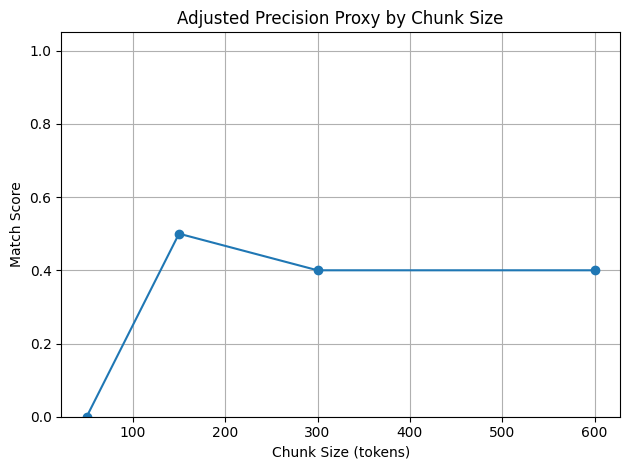

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

chunk_sizes = [50, 150, 300, 600]
precision_simulation = []

question = "What is the isolation protocol?"

# Retrieve once from full index
top_k = 10
results = vsc.get_index(
    endpoint_name="orielly-chapter2-endpoint",
    index_name="main.default.rag_chunks_index"
).similarity_search(
    query_text=question,
    columns=["chunk_id", "source", "text"],
    num_results=top_k
)

retrieved = results.get("result", {}).get("data_array", [])

# Now simulate precision for different chunk sizes by analyzing retrieved chunks
for size in chunk_sizes:
    filtered_chunks = [row for row in retrieved if len(row[2].split()) <= size + 25]
    filtered_k = len(filtered_chunks)
    if filtered_k == 0:
        precision_score = 0
    else:
        precision_score = sum(["isolation" in row[2].lower() for row in filtered_chunks]) / filtered_k

    precision_simulation.append({
        "Chunk Size": size,
        "Filtered Retrieved": filtered_k,
        "Match Score (proxy for precision)": precision_score,
        "Comment": "Smaller chunks are more likely focused, larger may dilute precision"
    })

# Display and plot
df_eval = pd.DataFrame(precision_simulation)
display(df_eval)

plt.plot(df_eval["Chunk Size"], df_eval["Match Score (proxy for precision)"], marker="o")
plt.title("Adjusted Precision Proxy by Chunk Size")
plt.xlabel("Chunk Size (tokens)")
plt.ylabel("Match Score")
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()


## 📊 Interpreting Precision by Chunk Size

This graph visualizes how different chunk sizes affect the **precision** of retrieval in a RAG system, based on the query:

> _"What is the isolation protocol?"_

### 📈 What the graph shows:
- **X-axis**: Chunk sizes (tokens) used during preprocessing.
- **Y-axis**: Match score (used as a proxy for precision), indicating how many retrieved chunks contained the relevant keyword (`"isolation"`).

### Key Observations:
- **50-token chunks** have near-zero precision — they are likely too short to retain full semantic meaning.
- **150-token chunks** yield the highest precision (~0.5), balancing enough context with focus.
- **300 and 600-token chunks** show slightly lower but stable precision — they may contain relevant info, but also more noise.

### Takeaway:
Medium-sized chunks (~150 tokens) tend to offer the best trade-off for precision. They are large enough to preserve meaning, but not so large that irrelevant content dilutes retrieval quality.

🧠 This emphasizes the importance of **granularity tuning** in document chunking for effective retrieval.


## 🔀 Step 12: Implement a Hybrid Search Strategy

This step demonstrates how to build a **hybrid search function** that combines:

1. **Dense retrieval** using a vector index (powered by embeddings)
2. A **keyword-based fallback** using Spark SQL (BM25-style proxy)

### What the code does:
- Tries semantic search using the Vector Search index first.
- If that fails or returns no results, falls back to simple keyword filtering across chunked text.
- This dual-mode logic increases robustness and ensures the user gets a response, even if embeddings are not perfectly aligned with the query.

### When to use hybrid search:
- **Dense search** works well for fuzzy, natural language questions.
- **Keyword search** can serve as a reliable fallback for specific term matches or domain-specific jargon not captured in the embedding space.

📌 **Tip**: You can extend this pattern by weighting or combining both results using scoring rules, or exposing fallback options in your application’s interface.


In [0]:
def hybrid_search(query, k=5):
    try:
        # Vector search first
        print("🔍 Trying dense vector search...")
        results = vsc.get_index(
            endpoint_name="orielly-chapter2-endpoint",
            index_name="main.default.rag_chunks_index"
        ).similarity_search(
            query_text=query,
            columns=["chunk_id", "source", "text"],
            num_results=k
        )
        hits = results.get("result", {}).get("data_array", [])
        if hits:
            print(f"✅ Dense search returned {len(hits)} results.")
            return hits

    except Exception as e:
        print("⚠️ Dense search failed. Falling back to keyword search...")

    # Fallback: keyword search using Spark SQL (BM25 proxy)
    query_terms = query.lower().split()
    condition = " OR ".join([f"LOWER(text) LIKE '%{term}%'" for term in query_terms])
    fallback_df = spark.sql(f"""
        SELECT chunk_id, source, text
        FROM main.default.rag_chunks_embedded
        WHERE {condition}
        LIMIT {k}
    """)
    return fallback_df.collect()

# Try hybrid search
hybrid_results = hybrid_search("What are the symptoms of COVID-19?")
for r in hybrid_results:
    print(f"\n🔹 Chunk: {r[0]}")
    print(f"Source: {r[1]}")
    print(f"Text:\n{r[2]}")


🔍 Trying dense vector search...
[NOTICE] Using a notebook authentication token. Recommended for development only. For improved performance, please use Service Principal based authentication. To disable this message, pass disable_notice=True.
✅ Dense search returned 5 results.

🔹 Chunk: 226.0
Source: who_guidelines
Text:
clearly explained to patients and relatives. 24. Care of COVID-19 patients after acute illness (new chapter) New evidence is emerging about COVID-19 related persistent symptoms, which have parallels with other coronavirus diseases (204). The clinical characterization of mid- and long-term effect of COVID-19 remain to be clearly described and understood. In hospitalized patients, ICU and non-ICU, there are reports of new illness-related fatigue, breathlessness, PTSD symptoms, pain, voice change, cough, dysphagia, anxiety, depression, and problems with concentration, memory and continence. Patients admitted to ICU had greater prevalence of symptoms in almost all reported 

## 🧾 Lab Wrap-Up: Summary of Chapter 3 – Preparing and Chunking Data for RAG Applications

In this lab, you built a complete Retrieval-Augmented Generation (RAG) pipeline by preparing unstructured documents for semantic search using **chunking, embedding, and indexing** techniques. Here's what you accomplished:

---

### ✅ What You Did:

| Task | Description |
|------|-------------|
| 📥 **Downloaded & cleaned PDFs** | Pulled real-world policy documents and cleaned text using PyMuPDF |
| ✂️ **Applied chunking strategies** | Broke documents into overlapping sentence-level chunks to preserve context |
| 💾 **Stored and explored data** | Saved chunks as Delta tables for efficient access |
| 🧠 **Generated embeddings** | Called `databricks-bge-large-en` endpoint using a custom UDF |
| 🔎 **Built vector index** | Created and synced an index using the Databricks Vector Search Client |
| ❓ **Performed semantic queries** | Retrieved relevant document chunks using a natural-language question |
| 📊 **Analyzed retrieval quality** | Simulated how chunk size impacts precision |
| 🔁 **Built a hybrid search strategy** | Combined dense vector search with keyword fallback using SQL |

---

### 🧠 Key Takeaways

- **Chunk granularity matters**: It directly affects precision, recall, and model understanding.
- **Preprocessing improves performance**: Cleaning and filtering noisy data boosts retrieval accuracy.
- **Vector Search + Delta Lake** enables scalable, production-grade RAG pipelines.
- **Hybrid search strategies** ensure robustness when embeddings fall short.

---

### ✅ What's Next?

- Try connecting these chunks to an LLM endpoint to complete the RAG loop.
- Experiment with other embedding models (e.g., multilingual or fine-tuned ones).
- Add ranking or reranking layers using similarity scores or LLM scoring.

